In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
# Reproducibility
seed = 42
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(seed)

In [3]:
# Load ResNet-50 with imagenet weights and exclude top layers
model = ResNet50(weights='imagenet', include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

## Create 10 clusters using given database

In [4]:
# Function to extract features from images
def extract_features(image_paths, model):
    features_list = []
    for img_path in tqdm(image_paths):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        features_list.append(features.flatten())
    return np.array(features_list)

# Images paths
data_dir = '../../Data/Raw'
data_subdir = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir)]
image_paths = [os.path.join(subdir, filename) for subdir in data_subdir for filename in os.listdir(subdir)]

# Exxtract features using ResNet-50
features = extract_features(image_paths, model)

# CLustering with KMeans (K=10)
kmeans = KMeans(n_clusters=10, n_init='auto', random_state=seed)
predicted_labels = kmeans.fit_predict(features)

100%|██████████| 5000/5000 [05:41<00:00, 14.64it/s]


## Show samples of images from clusters

Cluster 0:


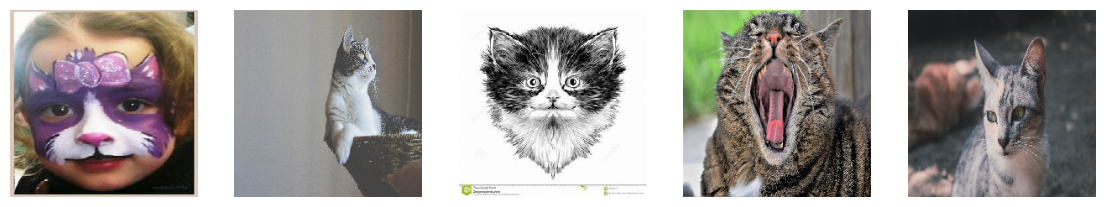

Cluster 1:


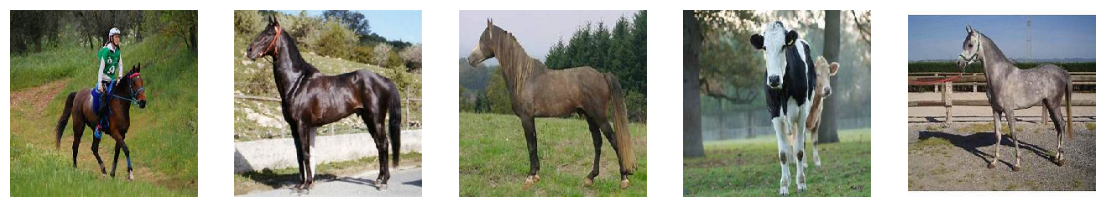

Cluster 2:


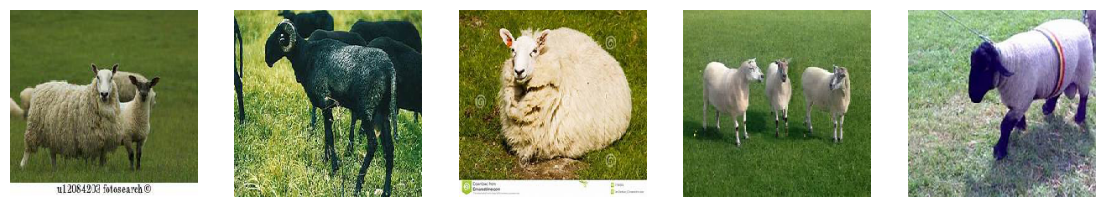

Cluster 3:


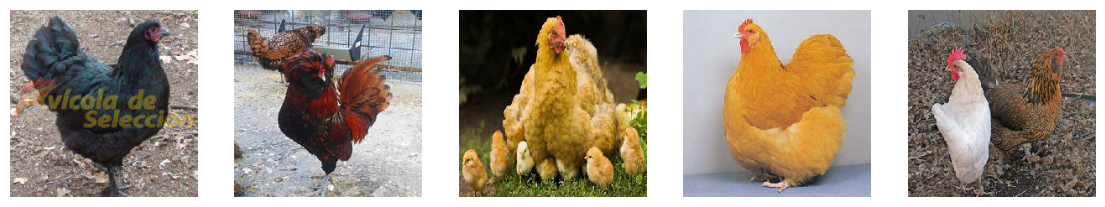

Cluster 4:


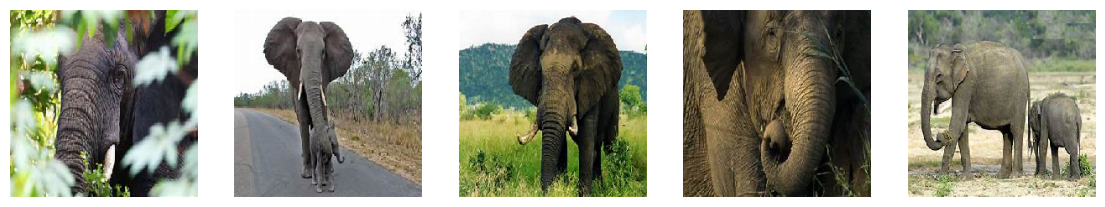

Cluster 5:


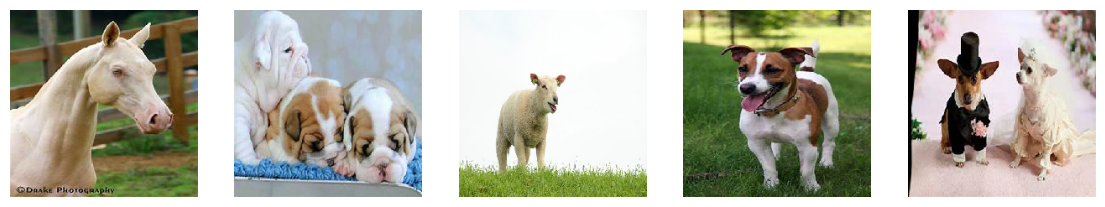

Cluster 6:


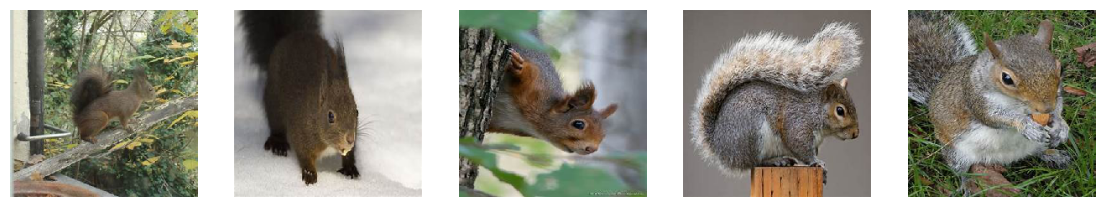

Cluster 7:


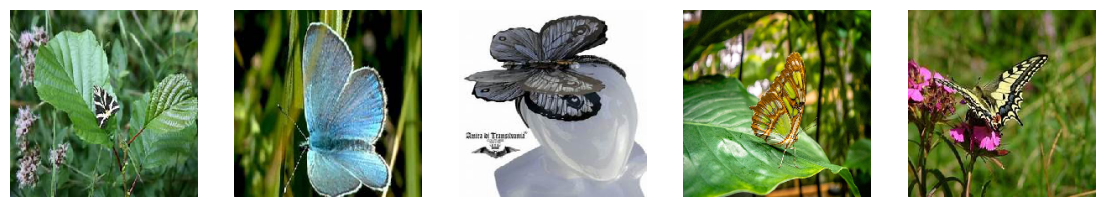

Cluster 8:


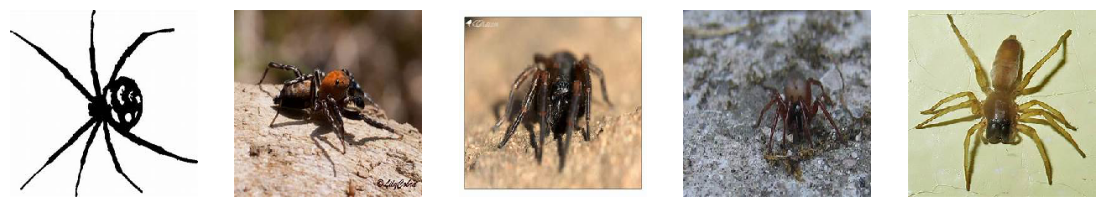

Cluster 9:


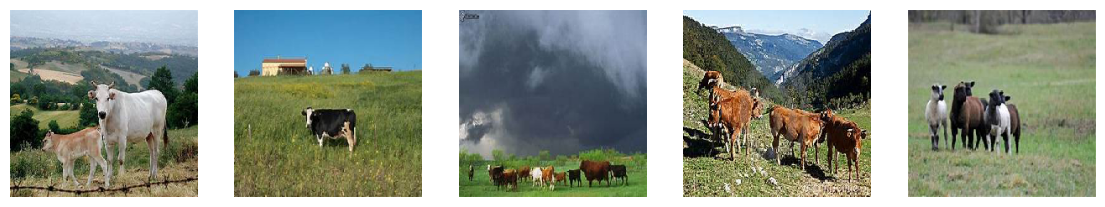

In [5]:
# Function to show images
def show_cluster_images(image_paths, labels, cluster_id):
    cluster_indices = np.where(labels == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, 5, replace=False)
    plt.figure(figsize=(14, 5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, 5, i+1)
        img = load_img(image_paths[idx], target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Show images for each cluster
for cluster_id in range(10):
    print(f"Cluster {cluster_id}:")
    show_cluster_images(image_paths, predicted_labels, cluster_id)


## Analyzing Clusters

Accuracy: 77.84%


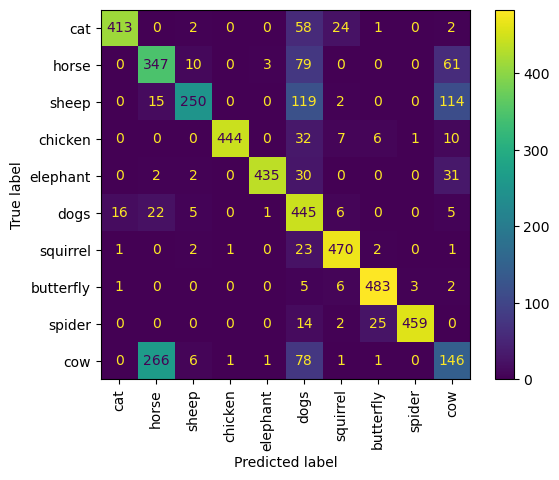

In [6]:
# Get true labels from image paths
true_labels = [os.path.basename(os.path.dirname(img_path)) for img_path in image_paths]

# Convert labels to numbers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
class_names = np.array(label_encoder.classes_)

# Calculate confusion matrix
confusion = confusion_matrix(true_labels_encoded, predicted_labels)

# Organize confusion matrix based on true labels
order = np.argmax(confusion, axis=0)
confusion = confusion[order]
class_names = class_names[order]

# Plot confusion matrix
ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
plt.xticks(rotation=90)

# Calculate accuracy
accuracy = np.trace(confusion) / np.sum(confusion)
print(f'Accuracy: {accuracy * 100 :.2f}%')


The model's accuracy of 77.84% indicates that it performed well in clustering the image database. The model was built on an unsupervised machine learning algorithm, which means that it did not have access to the real labels at any point during training. Despite this, the model was able to distinguish the 5000 images in the database very effectively and create 10 well-defined clusters, which were then compared to the true labels.

A deeper analysis of the confusion matrix reveals that the model had difficulty grouping cow images into the same cluster. This group had the highest classification error. Horses and sheep were two other groups that were not well identified, although they had fewer errors than cows. The model achieved precision of over 80% for all remaining groups, reaching an excellent result of 96.6% for butterflies.

As we can see, the unsupervised model performed well in clustering the image database even without any further training. One way to improve the model would be to retrain it using the selected image database, as it is already labeled.